# Maximising return on investment by optimising targetting using Uplift Modelling

Suppose you're a marketing business executive who is faced with a problem where you are spending way too much money on sending direct email advertisements on a cost-per-email basis to your entire customer base. Your strategy has been working for the past couple of years, however the number of successful conversions that your consistent email strategy has begun to dwindle in the last few months. It seems as though your customers have become more and more resilient to the communications, and its becoming a waste of resources to keep up with this brute force strategy. The money wasted on these email comms would probably do better into creating effective campaigns, or into consumer research.

Now this is a pretty basic problem, probably something that pretty much every established business has faced and has come up with some form of solution to solve. I am simply framing it this way so you (the reader) can get a sense of what this article is all about.

You call a meeting with your analytics guy and explain this has been stressing you out for the past few months and have been losing too much sleep, and your eyebrows have started greying because of it. He told you about a new technique they've been studying in their spare time called Uplift modelling which might help solve them problem, explaining that the modelling will identify the customers who have a high propensity to convert, and so you can optimise your email comms to just those customers and then use the rest of the money to give bonuses to the analytics team.

"But how is that any different to running a classical A/B test and then, classifying those who will convert based on it, and targetting them through that?"

He explains that Uplift modelling takes it a step further than A/B testing, and adds value on traditional A/B testing by:

- **Identify how the treatment affects each individual** - A/B testing measures the overall impact of the direct emails on the population on average which can identify whether they would convert, but won't tell us if they would have converted anyway. While Uplift modelling can quantify the likelihood of converting for **each individual**. This helps identify those who have the highest propensity to convert (Persuaders) as well as those who might churn as a result of receiving the emails (Sleeping Dogs). Uplift modelling adds an additional layer of detail on top of traditional modelling, further optimising targetting.
- **Segmentation based on treatment** - We can start classify groups of people based on how they react to the treatments, and look at the relationships of their demographics, or other information we have about them. With this combined knowledge, we can figure out a personalised advertising strategy that changes depending on their reactions to the kinds of advertising they receive. For instance, if they reacted badly to one type of email comms, we could instead target them (or someone who is similar to them) next time with a different form of communication.


He also explains that with uplifting modelling the following questions can be answered:

- How can we optimise our email communications to target customers who are most likely to convert?
- How can we identify customers who might be adversely affected by our email communucations?
- How can we develop a personalised advertising strategy for different customer segments?

This article aims to explore the use of uplift modeling in the context of answering the three questions above. It also served as a journey for me to learn this new technique. Enjoy!

Uplift modelling requires an A/B test to have taken place already, where there is a treatment being applied to a sample of respondents who are *representatively proportionate* to a sample of respondents who did not experience the treatment. It is extremely important to control for all variables to the best we can in the A/B test, because otherwise we can't be certain that any difference in the outcome (conversion) is as a result of the treatment itself, or a confounding variable that defines the difference between the two groups.

The dataset used in this notebook to demonstrate Uplift modelling can be found on Kaggle in the link below. We will start off with basic EDA to understand the dataset.

The content of the dataset is as follows:

*The dataset was created by The Criteo AI Lab .The dataset consists of 13M rows, each one representing a user with 12 features, a treatment indicator and 2 binary labels (visits and conversions). Positive labels mean the user visited/converted on the advertiser website during the test period (2 weeks). The global treatment ratio is 84.6%. It is usual that advertisers keep only a small control population as it costs them in potential revenue.*

*Following is a detailed description of the features:*

*f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11: feature values (dense, float)*
*treatment: treatment group (1 = treated, 0 = control)*
*conversion: whether a conversion occured for this user (binary, label)*
*visit: whether a visit occured for this user (binary, label)*
*exposure: treatment effect, whether the user has been effectively exposed (binary)*

It would have been good to use a dataset that has features that were named and appropriate for the business case, which would help in framing the business problem further to look at segmentation via uplift modelling, but nevertheless, it's a good enough dataset to explore the technique.

### Data Exploration

I won't spend too much time on data exploration here as I want to draw focus on the modelling. Here we are just going through basic data inspection to make sure everything is all right.

In [127]:
#Dataset found on Kaggle
#https://www.kaggle.com/datasets/arashnic/uplift-modeling

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('criteo-uplift-v2.1.csv')

data.columns # read columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')

In [128]:
data.isnull().sum() # check missing data

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [129]:
data['treatment'].value_counts() # counting cases of treatment group

treatment
1    11882655
0     2096937
Name: count, dtype: int64

In [130]:
data['exposure'].value_counts() # counting cases of exposure group

exposure
0    13551380
1      428212
Name: count, dtype: int64

In [131]:
data['conversion'].value_counts() # counting cases of conversions

conversion
0    13938818
1       40774
Name: count, dtype: int64

There are 13 million rows of data, with 85% of the dataset is treatments, and only 3% of them are exposed. The dataset defines those exposed as those who were treated, and successfully saw the treatment. For simplification purposes, we will just simply assume that those exposed are the treatment group.

There are a miniscule amount of conversions compared to treatments. This is probably representative of the context of our story of email communications.

Let's take our group of those were exposed, and then take a random sub-sample of those not exposed and assume that is equal to the exposed group.

In [132]:
exposure_1_count = (data['exposure'] == 1).sum()
exposure_1_rows = data[data['exposure']== 1]

exposure_0_rows = data[data['exposure'] == 0].sample(n=exposure_1_count,random_state = 10) #sub-sampling down
df = pd.concat([exposure_1_rows,exposure_0_rows])


In [133]:
df['exposure'].value_counts() # check work

exposure
1    428212
0    428212
Name: count, dtype: int64

Cool it looks like it worked successfully. Now we have even groups of exposed vs not exposed.

Great, let's jump straight into the modelling with this dataset.

## Modelling
Now to split the dataset into a train and test set. Since we are using exposure as the treatment and conversion as the outcome variable, let's drop the visit and treatment column.

In [134]:

from sklearn.model_selection import train_test_split

train, test = train_test_split(df.drop(columns = ['visit','treatment']), test_size = 0.3, random_state = 1)


Now to break it up further into x,y, and the treatment variables.

In [135]:

x_train_sk = train.drop(['conversion','exposure'],axis = 1)
y_train_sk = train['conversion']
trtmnt_train_sk = train['exposure']

x_test_sk = test.drop(['conversion','exposure'],axis = 1)
y_test_sk = test['conversion']
trtmnt_test_sk = test['exposure']

Let's build out our models now. I've decided to use xgboost for this demonstration, but there are many that are available such as randomforest, gbm, logistic regression, svms and even neural networks. Definitely worth a try with many pending time.

In [136]:
from sklift.models import SoloModel,TwoModels
from xgboost import XGBClassifier

estimator = XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

estimator_trt = XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)

estimator_ctrl = XGBClassifier(learning_rate = 0.1,
                          max_depth = 6,
                          min_child_weight = 100,
                          objective = 'binary:logistic',
                          seed = 42,
                          gamma = 0.1,
                          silent = True,
                          n_jobs=2)
Slearn_xgb = SoloModel(estimator)
Tlearn_xgb = TwoModels(estimator_trmnt = estimator_trt,
                       estimator_ctrl = estimator_ctrl,
                       method = 'vanilla')

Slearn_xgb = Slearn_xgb.fit(x_train_sk,y_train_sk,trtmnt_train_sk)
Tlearn_xgb = Tlearn_xgb.fit(x_train_sk,y_train_sk,trtmnt_train_sk)

[20:37:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:38:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[20:38:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.



Here we used built two different uplift modelling techniques, but the premise is the same between them. We basically get the prediction estimates of the models for treatment = 1, as well as when treatment = 0 for the each user, and then subtract them together, which gives us the uplift score. This makes sense if we consider a persuadable, someone who has a high propensity to convert will have a high score when treament = 1, and a also a low outcome when treatment = 0. Thus have high uplift score. A sleeping dog will have a lower score when treatment = 1, and higher score when treatment = 0, leaving us with a negative score.

- **Slearn** stands for Single Learner, meaning we are using the same model to predict conversion, regardless of treatment or no treatment. We then run the same model with Treament = 1, and Treatment = 0 separately, and take the difference between them, which leaves us the uplift score.
- **Tlearn** stands for Two Learner, meaning we are using two separate models. One for treatment = 1 and one for treatment = 0. We do the same by taking the difference between Treatment = 1 and Treatment = 0, however what distinguishes this apart from an Slearn is that it may capture uniqueness between the treatment vs no treatment group, that the single model approach won't. Usually ends up in more accuracy but not always the case.

The SoloModel and TwoModels functions from sklearn are amazing functions that simplify the process for us. I'm deliberately using them in this case to simplify our code, but when learning, it's worth figuring out how to code an S-Learn and T-learn from scratch. Some helpful resources that I used to do this can be found in the references at the bottom.

Now we can make our predictions of the uplift scores.

In [137]:
uplift_sm_xgb = Slearn_xgb.predict(x_test_sk) #Uplift scores for Slearn
uplift_tm_xgb = Tlearn_xgb.predict(x_test_sk) #Uplift scores for Tlearn

I'm just defining a useful function for our next part.

In [138]:
#### Function credit to https://www.kaggle.com/code/milara/uplift-modeling-using-advertising-data/notebook
def get_tc(treatment,target):
    """
    Function that returns helps to select the users that were in the control group and have a positive response
    
    Parameters:
    ------------
    treatment = treatment
    target = the response 
    """    
    if not target:
        return 0
    elif not treatment:
        return 1
    else:
        return 0
    
def compute_gain(df_x, uplift, treatment, y, rnd = False):
    """
    Function that computes the cumulative gains in a dataframe
    
    Parameters:
    ------------
    uplift = arr with the predicted uplifts by the models
    trtment = arr with the treatment indicator (test)
    y = arr target variable (test)
    rnd = bool indicating if random selection
    """
    e = 0.0000000000001 # to avoid divisions by zero
    base = pd.DataFrame({'uplift':uplift, 'treatment':treatment.values, 'target': y.values})

    df = pd.concat([df_x,base], axis = 1)
    
    #sort based on the flag
    if rnd:
        df = df.sample(frac=1).reset_index().drop('index', axis =1)
    else:
        df = df.sort_values(by='uplift', ascending = False).reset_index().drop('index', axis =1)
    
    #Compute the cumulative treatment size
    df['cum_trs'] = df['treatment'].cumsum(axis=0)

    #Compute the cumulative control size
    df['cum_crs'] = (df.index+1) - df['treatment'].cumsum(axis=0)
    
    #Compute target given treatment
    df['ttr'] = df['treatment'] * df['target']
    
    #Compute target given control
    df['tcr'] = df.apply(lambda x: get_tc(x.treatment, x.target), axis=1)
    
    #Compute cumulative target given treatment
    df['cum_ttr'] = df['ttr'].cumsum(axis=0)
    
    #Compute cumulative target given control
    df['cum_tcr'] = df['tcr'].cumsum(axis=0)
    
    #Compute cumulative gain from one to uplift [descent]
    df['cum_gain'] = (df['cum_ttr']/(df['cum_trs']+e)) - (df['cum_tcr']/(df['cum_crs']+e))
    
    #Compute cumulative gain from zero to uplift [ascending]
    df['cum_gain2'] = df['cum_gain']*(df['cum_trs']+df['cum_crs']+e)/ len(df)
    
    return df   

Thank you so much Milara from Kaggle for this wonderful function. It essentially works out the cumulative uplift compared to no treatment, that is, the percentage of uplift compared to no treatment at each step as we iterate through the dataset.

To put the math behind the function, the 'cum_gain' column is calculated by:

$$
\sum_{i=1}^{n}\textbf{Gain}_{i}=\frac{\sum_{i=1}^{n}\textbf{P}(Target_{i}|Treatment_{i})}{\sum_{i=1}^{n}Treatment_{i}} - \frac{\sum_{i=1}^{n}{\textbf{P}(Target_{i}|Control_{i})}}{\sum_{i=1}^{n}Control_{i}}
$$

This essentially gives us for each iteration through the dataset, the relative gain in the outcome compared to no treatment. So if for instance if we reach the most probable 20% of users, and the cumulative gain is 0.1, then that means the model will achieve 10% uplift in conversions.

The 'cum_gain2' column flips this around and gives us a proportion of gain relative to all users. This is a useful way for us to compare models against each other on a chart. It's done by:

$$
\sum_{i=1}^{n}\textbf{Gain}\sim \textbf{n} = \sum_{i=1}^{n}\textbf{Gain}_{i} * \frac{\sum_{i=1}^{n}Treatment_{i}+\sum_{i=1}^{n}Control_{i}}{n}
$$

So we will use the values of cum_gain2 in the analysis.

In [139]:
#set-up to run function
x_test_sk = x_test_sk.reset_index().drop('index',axis = 1)
trtmnt_test_sk = trtmnt_test_sk.reset_index(drop=True)
y_test_sk = y_test_sk.reset_index(drop=True)

sm_xgb_gain = compute_gain(x_test_sk,uplift_sm_xgb,trtmnt_test_sk,y_test_sk)
tm_gbm_gain = compute_gain(x_test_sk,uplift_tm_xgb,trtmnt_test_sk,y_test_sk)
rnd_gain = compute_gain(x_test_sk,uplift_tm_xgb,trtmnt_test_sk,y_test_sk,True)


Using the output, we can put together our cumulative gains curve to compare our models, and also against the random model which represents the approach of if we targetted users at random to receive treatment.

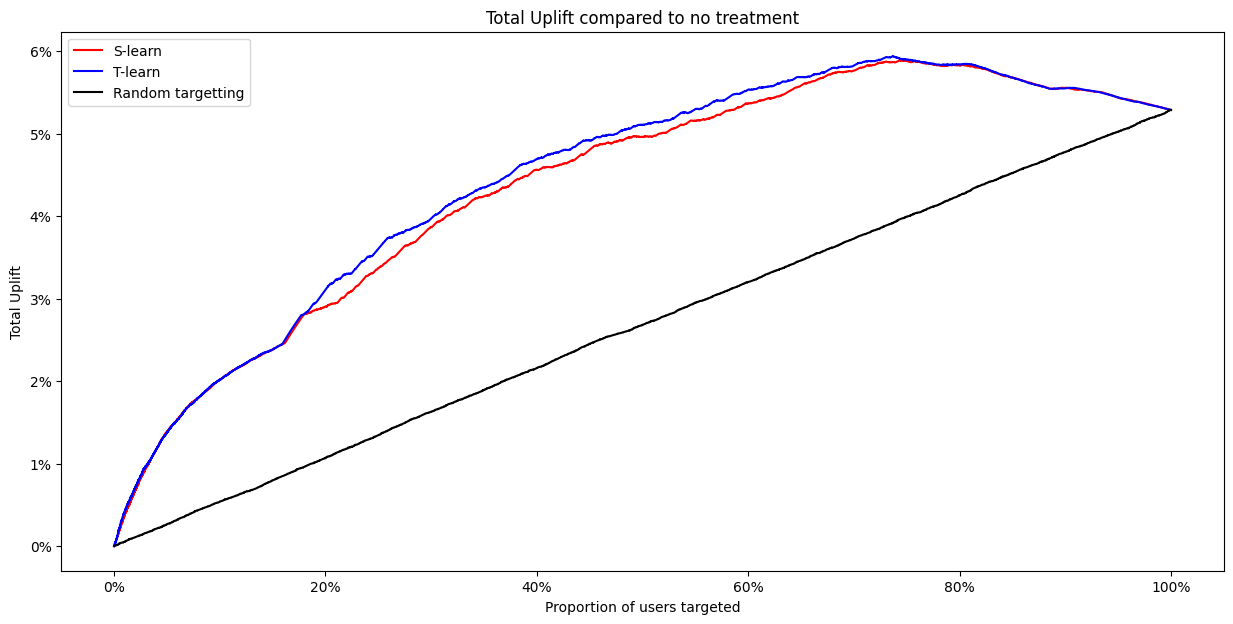

In [140]:

from matplotlib.ticker import PercentFormatter
_, axes = plt.subplots(figsize=(15, 7))
instances=np.arange(0, 1, (1/len(sm_xgb_gain)))
axes.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
axes.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))

axes.set_title("Total Uplift compared to no treatment")
axes.set_xlabel("Proportion of users targeted")
axes.set_ylabel("Total Uplift")
axes.plot(instances, sm_xgb_gain['cum_gain2'].values, '-', color="red",label="S-learn")
axes.plot(instances, tm_gbm_gain['cum_gain2'].values, '-', color="blue",label="T-learn")
axes.plot(instances, rnd_gain['cum_gain2'].values, '-', color="black",label="Random targetting")
axes.legend(loc="best")
plt.show()



The Cumulative gain curve above shows us a comparison between three different approaches to targetting our sample in our email communications. To understand this chart a bit better, the three lines meet at at point just over 5% uplift, because this means by reaching 100% of users with the treatment, we will achieve 5% conversions more than no treatment, i.e. not sending out any comms. But the point of this analysis is to answer the three questions posed at the start of this article, and here we'll be able to answer the first question.

**How can we optimise our email communications to target customers who are most likely to convert?**

If we take for instance the total uplift at 20% users targetted, the S-learn and T-learn models represent around 3% total uplift, while the random model does about 1% uplift. That's 3x better than no strategy! (random targetting) The difference in these approaches is that the ordering of the users being targetted is different, because with the S-learn and T-learn approaches, we're targeting those with the highest uplift scores first, aka the highest propensity to convert as a result of the treatment. This way, we can figure out if its even worth the extra 2% uplift, but at a cost of the remaining 80% of the users.

We can see that the T-learn approach does a bit better than S-learn after the 20% sample, so if the decision was to target more than just 20% of the sample, it would be better to use the T-learn.

At this point, we can also answer the second question.

**How can we identify customers who might be adversely affected by our email communucations?**

We commonly refer to this group of customers colloquially as *sleeping dogs*, because we don't ever want to disturb a sleeping dog who might get all angry about being woken up. Typically, we consider those who have a negative uplift score as a sleeping dog, because the maths tell us that if the answer is negative when we subtract the prediction when treatment = 0 away from the prediction from treatment = 1, implies that the the treatment has a *negative* effect on the outcome.

In summary:

- High positive uplift score: Persuadables
- Low positive uplift score: Sure thing (will convert regardless of treatment)/ Lost cause (won't convert regardless of treatment) - We can't discern -the difference between them based on the uplift score
- Negative uplift score: Sleeping dog

In [141]:
sum(uplift_tm_xgb<0) #count how many sleeping dogs

0

It's not typical that we don't have any sleeping dogs in this dataset and could be for a variety of reasons and these are two of them.

- **Data problem** We know that the number of conversions in this is extremely low relatively, so that could effect the outcome. We also sub-sampled the non-exposures to match the exposures so that might have something to do with it
- **Model problem** The T-learn uplift model might not by capturing it properly, so would be good to interrogate trying different models

Sleeping dogs are a really good way to figure out how to tailor communications, as we'll be able to get a demographic and other variable view on why they might be negatively responding to communications. With analysis on the treatment itself (looking at the type of email comms), perhaps it is not personally relevant to them, causing them to see it as spam. A marketing company can also connect a churn variable to the data to get a more accurate view on whether the comms actually caused them to run away.

As this is a toy problem, let's just assume there are no sleeping dogs and perhaps we can just reframe the question to identifying the customers who have lowest propensity by our email communications.

In [142]:
print(max(uplift_tm_xgb)) # to estimate a cut-off
print(min(uplift_tm_xgb)) # to estimate a cut-off
sum(uplift_tm_xgb<0.005)/len(uplift_tm_xgb)

0.58403206
0.001333231


0.1310016814049072

Assuming a cut-off of uplift score of 0.005 being those who have low propensity. We see it makes up about 13% of the dataset. We could do a similar analysis to what I mentioned about sleeping dogs but instead for these sure things/lost causes, and perhaps we might even be able to build another classification tool to see what makes the difference between them.


### Feature Importance by Uplift group

By defining the groups by the uplift score, we will always be able to look at what makes them part of that group. This next part tries to answer the last question

*How can we develop a personalised advertising strategy for different customer segments?*

by looking at the importances of the features that went into classifying them. We do this by breaking up the data into 3 groups by their uplift score. For simplicity sake, I chose the three groups - 20% being the persuadables (highest uplift sc0re), the middle 20% - 80%, and the last 20% based on the cumulative gain chart above. 

I've also selected the T-learn model since it was the better one out of the S-learn and T-learn.

In [143]:

tm_gbm_gain_imp = tm_gbm_gain.copy() 

split1 = int(len(tm_gbm_gain_imp)*0.2) # create our splits at 20% of the modelled data
split2 = int(len(tm_gbm_gain_imp)*0.8) # at 80%

prof1 = tm_gbm_gain_imp.iloc[:split1]
prof2 = tm_gbm_gain_imp.iloc[split1+1:split2]
prof3 = tm_gbm_gain_imp.iloc[split2+1:]

With our three profiles, we can now run any machine learning model and get their importances. I've chosen randomforest to use its simple feature_importances_ method.

In [144]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier()
model2 = RandomForestClassifier()
model3 = RandomForestClassifier()

# modeling for each group of data
mod_prof1 = model1.fit(prof1.iloc[:,:12],prof1.iloc[:,14])
mod_prof2 = model2.fit(prof2.iloc[:,:12],prof2.iloc[:,14])
mod_prof3 = model3.fit(prof3.iloc[:,:12],prof3.iloc[:,14])


We've got our three separate models built, now to just get their importances out then popping them into a dataframe and visualising.

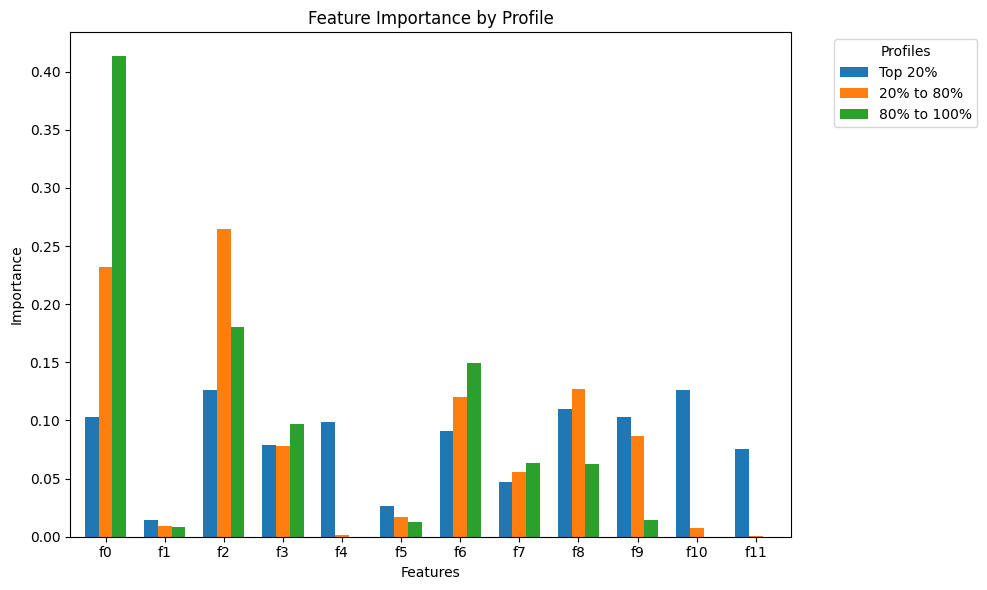

In [124]:

results1 = mod_prof1.feature_importances_
results2 = mod_prof2.feature_importances_
results3 = mod_prof3.feature_importances_

results = pd.DataFrame({'Top 20%':results1,"20% to 80%" : results2,"80% to 100%":results3})
results.index = [f'f{i}' for i in range(len(results))]

ax = results.plot(kind='bar', figsize=(10, 6),width=0.7)
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Feature Importance by Profile')
plt.xticks(rotation=0) 
plt.legend(title='Profiles', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()


It's shame that our dataset doesn't define the features and we're stuck with f labels. Properly defined features would help us make better sense of the results, and we could potentially work out whether each is a positive or negative association with conversions. Alternatively, there are also other importance algorithms that can determine negative or positive importances, but for the sake of brevity, we'll stick with this.

Here are some insights that we can gain.

- f0 is the most important feature for our 80% - 100% group. There is likely some relationship with f1 and their propensity to convert. Perhaps it's a feature that defines their age, and the email communication is more relevant to an older age group, or the other way around? Importance simply says its a defining feature to classify yes from no or no from yes.
- features are relatively balanced for our top 20% group. This is interesting as our initial assumptions might point to a standout defining feature which determines whether someone converts or not, and since our top cohort - remember these are the guys that might have the highest chance of converting when applying the treatment. This is indicitive that this group are simply very favourable to the company and there isn't some kind of behavioural variable (assuming thes variables define their behaviour with the company) that defines them, and instead there's something attitudinally perhaps.
- f0 and f2 are about equally as important to the 20% - 60% group. This is a larger group, so it's not weird that it's a bit more balanced. With some broader definitions of the variables, we could make intuitive sense of what might be going on and propose further analysis or research into explaining what might be going on.

Looking at importances of the variables by the uplift groups is a great starting point to which we can start to think about how we can develop personalised targetting strategies for them. As mentioned earlier, there may even be confident strategies in place to target those sleeping dogs who might churn if contacted too frequently, and other strategies to get the persuadables on board.


### Conclusion

In this article, I went through a quick walk-through of how to run uplift modelling and its use case in a marketing setting on answering three questions - how to optimise targetting for more conversions and save money compared to no strategy, how to identify customers who would be adversely affected (though the data didn't find any), and how to think about developing personalised strategies based on what we know about the customers.

It utilises both a S-learn and T-learn modelling, to compare and contrast different learning methods. Further work can be done with different models, as there are a few more different models known for Uplift modelling, as well as parameter tuning which can improve the uplift even more. We could also use cross-validation on the training set to ensure we have a generalised model.

Although the dataset could have been more developed and nuanced to allow for deeper analysis, it served as a great foundation to apply this technique with a marketing frame of mind.

### References

- [1] The Criteo AI Lab, "Uplift Modeling , Marketing Campaign Data", https://www.kaggle.com/arashnic/uplift-modeling
- [2] Milara, "Uplift modeling using Advertising Data", https://www.kaggle.com/code/milara/uplift-modeling-using-advertising-data/notebook
- [3] Steve Klosterman, "Supercharging customer touchpoints with uplift modeling", https://www.steveklosterman.com/uplift-modeling/
- [4] Robert Yi, "Pylift: A Fast Python Package for Uplift Modeling", https://www.aboutwayfair.com/data-science/2018/10/pylift-a-fast-python-package-for-uplift-modeling/
- [5] pylift documentation https://pylift.readthedocs.io/en/latest/
- [6] Shelby Temple, "uplift Modeling: A Quick Introduction, https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0
- [7] scikit-uplift documentation https://www.uplift-modeling.com/en/latest/user_guide/models/solo_model.html
- [8] Amy @GrabNGoInfo, 'Explainable S-Learner Uplift Model Using Python Package CausalML, https://medium.com/grabngoinfo/explainable-s-learner-uplift-model-using-python-package-causalml-a3c2bed3497c
- [9] Code Emporium, "Causal Inferece with Machine Learning - EXPLAINED!", https://www.youtube.com/watch?v=MFnOYNU5sbk&ab_channel=CodeEmporium
